In [8]:
using Pkg

Pkg.activate("../CompTop2022")
Pkg.add("BenchmarkTools")
Pkg.add("StaticArrays")
Pkg.add("Plots")
Pkg.add("Distances")
Pkg.add("Combinatorics")

using BenchmarkTools, StaticArrays, Plots, Distances, Combinatorics

  Activating project at `~/Desktop/Doktor/Lehre/Exercise5/CompTop2022`
    Updating registry at `~/.julia/registries/General.toml`
┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = Downloads.RequestError("https://pkg.julialang.org/registries", 6, "Could not resolve host: pkg.julialang.org", Downloads.Response(nothing, "https://pkg.julialang.org/registries", 0, "", Pair{String, String}[]))
└ @ Pkg.Registry /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.7/Pkg/src/Registry/Registry.jl:82
   Resolving package versions...
  No Changes to `~/Desktop/Doktor/Lehre/Exercise5/CompTop2022/Project.toml`
  No Changes to `~/Desktop/Doktor/Lehre/Exercise5/CompTop2022/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/Doktor/Lehre/Exercise5/CompTop2022/Project.toml`
  No Changes to `~/Desktop/Doktor/Lehre/Exercise5/CompTop2022/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/Doktor/Lehre/Exercise5/C

# Cech and Rips complexes

In this exercise we will implement the `miniball` algorithm from [lecture 9](https://moodle2.uni-potsdam.de/pluginfile.php/2383306/mod_resource/content/1/Lecture_9_24May.pdf) and then use it to construct a Cech complex for a given radius $r$ on a set of points $S$. Furthermore we will also implement a function that constructs the Rips complex on $S$ with radius $r$.

Consider the following struct that defines a $T-Ball$ where $T$ is an `Int` representing the dimension. An uppercase $T$ is an unusual choice for a variable representing dimensions, however it is the standard letter to indicate some template variable. We will stick to this convention. 

In [9]:
struct Ball{T}
    center::SVector{T, Float64}
    radius::Float64
end   

Although we defined a general dimension struct `Ball`. We will stick to two dimensions for this task. The following helperfunction `find_enclosing_circle_2d` takes an index set and a set of points as input. The index set is intended to contain the indices of the points that lie on the boundary. Note that in two dimensions a circle is uniquely determined by three points on its boundary. 

In [10]:
function find_enclosing_circle_2d(boundary_subset::Vector{Int}, points::Vector{Vector{Float64}})
   
    if length(boundary_subset) == 0
        # Moving the center to Inf,Inf and setting the radius to zero means 
        # nothing can be contained in the ball as long as we are in R^2
        return Ball{2}(@SVector[Inf,Inf], 0.0)
    end
    
    if length(boundary_subset) == 1
        x,y = points[boundary_subset[1]]
        return Ball{2}(@SVector[x,y], 0.0)
    end

    if length(boundary_subset) == 2
        p = points[boundary_subset[1]]
        q = points[boundary_subset[2]]
        x,y = (p+q)/2.0
        return Ball{2}(@SVector[x,y], euclidean(p,q)/2.0)
    end
    
    # We are ignoring all indexed points larger 4 because a circle in 2D is 
    # uniquely determined by three boundary points.
    # Code from https://www.geeksforgeeks.org/equation-of-circle-when-three-points-on-the-circle-are-given/
    
    x1, y1 = points[boundary_subset[1]]
    x2, y2 = points[boundary_subset[2]]
    x3, y3 = points[boundary_subset[3]]
    
    x12 = x1 - x2;
    x13 = x1 - x3;
 
    y12 = y1 - y2;
    y13 = y1 - y3;
 
    y31 = y3 - y1;
    y21 = y2 - y1;
 
    x31 = x3 - x1;
    x21 = x2 - x1;
 
    sx13 = x1^2 - x3^2;

    sy13 = y1^2 - y3^2;
 
    sx21 = x2^2 - x1^2;
    sy21 = y2^2 - y1^2;
 
    f = (((sx13) * (x12) + (sy13) *
          (x12) + (sx21) * (x13) +
          (sy21) * (x13)) / (2.0 *
          ((y31) * (x12) - (y21) * (x13))));
             
    g = (((sx13) * (y12) + (sy13) * (y12) +
          (sx21) * (y13) + (sy21) * (y13)) /
          (2.0 * ((x31) * (y12) - (x21) * (y13))));
 
    c = (-x1^2 - y1^2 -
         2.0 * g * x1 - 2 * f * y1);

    h = -g;
    k = -f;
    r = sqrt(h * h + k * k - c);

    return Ball{2}(@SVector[h,k], r)
end 

find_enclosing_circle_2d (generic function with 1 method)

The following functions can be used to plot balls and point sets. These may be helpful for debugging.

In [11]:
# circle_shape and plot_ball are based on
# https://discourse.julialang.org/t/plot-a-circle-with-a-given-radius-with-plots-jl/23295/3
function circle_shape(c, r)
    θ = LinRange(0,2*π, 500)
    c[1] .+ r*sin.(θ), c[2] .+ r*cos.(θ)
end

function plot_ball!(fig, b::Ball)
    plot!(fig, circle_shape(b.center,b.radius), 
        seriestype = [:shape], 
        lw = 0.5,
        c= :blue, 
        linecolor = :black, 
        legend = false,
        fillalpha = 0.2, 
        aspect_ratio = 1)
end 

function plot_ball_and_points(ball::Ball, points::Vector{Vector{Float64}})
    fig = scatter(getindex.(points, 1), getindex.(points, 2))
    plot_ball!(fig, ball)
    fig
end

plot_ball_and_points (generic function with 1 method)

The following is an example of this visualization.

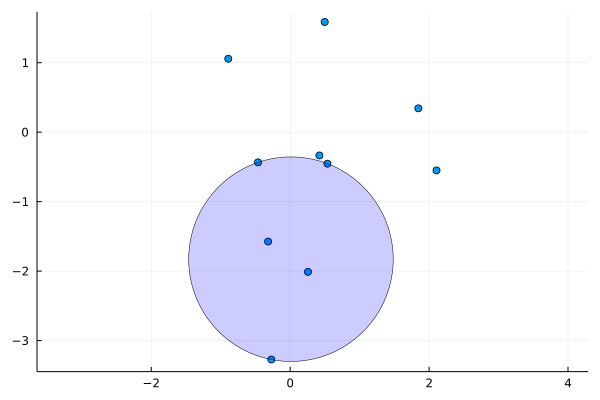

In [12]:
points = [randn(2) for _ in 1:10]
b = find_enclosing_circle_2d([1,2,5], points)
plot_ball_and_points(b, points)

Your task is to write the following three functions: 
* `mini_ball`
* `chech_complex`
* `rips_copmplex`

Think about what helper functions you might need. The output of `miniball` should be a `Ball`. The output of the other functions should be a `Vector{Vector{Int}}` representing the generated abstract simplicial complex. An example would be the abstract simplicial complex of a triangle with all its faces. 
$\{\{1\}, \{2\}, \{3\}, \{1,2\}, \{1,3\}, \{2,3\}, \{1,2,3\}\}$

Note that we did not include the empty set $\emptyset$, since we do not require it to be represented in the output vector of the functions.


In [13]:
function is_in_ball(point::Vector{Float64}, b::Ball)
    dist = euclidean(point, b.center)
    return dist < b.radius || isapprox(dist, b.radius)
end

is_in_ball (generic function with 1 method)

In [14]:
function mini_ball(τ, ν, points)     
    if τ == Int[]
        return find_enclosing_circle_2d(ν, points)
    else
        index_u = rand(1:length(τ))
            
        u = τ[index_u]
        μ = [elem for elem in ν]
        
        ω = [elem for elem in τ if elem != u]
        b = mini_ball(ω, μ, points)
                
        if !is_in_ball(points[u], b)    
            push!(μ, u)
            b = mini_ball(ω, μ, points)
        end
    end
    return b
end

mini_ball (generic function with 1 method)

In [15]:
function chech_complex(points, r)
    complex = []
    for σ in collect(powerset(collect(1:length(points)), 1))
        if mini_ball(σ, Int[], points).radius < r
            push!(complex, σ)
        end
    end
    complex
end

chech_complex (generic function with 1 method)

In [26]:
points = [[0.6722160492277268, 0.6999383545999939],
 [-0.37682086050714175, 0.37126922448266264],
 [1.468937306183007, -0.2687385812642815],
 [0.8397029901863983, -0.1815031668940114],
 [2.148159755905217, 1.5104610118822424],
 [1.8883608408716654, 1.9017511847501798],
 [-0.0690161774084484, -0.16357579722103666],
 [0.458594683733351, -0.05956829787443805],
 [-1.3252094574927165, 1.1124175613596903],
 [-0.2561915220307307, -0.5003762140518727]]

complex = chech_complex(points, 0.5)
println(complex)
@assert complex == [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], 
    [1, 4], [1, 8], [2, 7], [2, 8], [2, 10], [3, 4], [4, 7], [4, 8], [5, 6], [7, 8], [7, 10], [8, 10], 
    [1, 4, 8], [2, 7, 8], [2, 7, 10], [4, 7, 8], [7, 8, 10]]

Any[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [1, 4], [1, 8], [2, 7], [2, 8], [2, 10], [3, 4], [4, 7], [4, 8], [5, 6], [7, 8], [7, 10], [8, 10], [1, 4, 8], [2, 7, 8], [2, 7, 10], [4, 7, 8], [7, 8, 10]]


In [17]:
function is_diam_sufficiently_small(σ, points, r)
    # Implementation farrrrr from optimal. I am a bit lazy right now though. 
    for ν ∈ σ
        for μ ∈ σ
            if euclidean(points[ν], points[μ]) > 2*r
                return false
            end
        end
    end
    true
end


function rips_complex(points, r)    
    complex = []
    for σ in collect(powerset(collect(1:length(points)), 1))
        if is_diam_sufficiently_small(σ, points, r)
            push!(complex, σ)
        end
    end
    complex
end

rips_complex (generic function with 1 method)

In [27]:
complex = rips_complex(points, 0.5) 
println(complex)
@assert complex == [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], 
[1, 4], [1, 8], [2, 7], [2, 8], [2, 10], [3, 4], [4, 7], [4, 8], [5, 6], [7, 8], [7, 10], [8, 10], 
[1, 4, 8], [2, 7, 8], [2, 7, 10], [2, 8, 10], [4, 7, 8], [7, 8, 10], 
[2, 7, 8, 10]]

Any[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [1, 4], [1, 8], [2, 7], [2, 8], [2, 10], [3, 4], [4, 7], [4, 8], [5, 6], [7, 8], [7, 10], [8, 10], [1, 4, 8], [2, 7, 8], [2, 7, 10], [2, 8, 10], [4, 7, 8], [7, 8, 10], [2, 7, 8, 10]]
